## 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### Определение статистик

In [2]:
def midrange(x):
    return 0.5 * (np.min(x) + np.max(x))


def trimmed_mean(x, k):
    x_sorted = np.sort(np.asarray(x))
    n = len(x_sorted)
    g = int((k / 2) * n)
    return np.mean(x_sorted[g : n - g])



### Генерация исходной совокупности и параметры погрешностей по заданию


In [3]:
def make_base_sample(seed=0):
    rng = np.random.default_rng(seed)
    x99 = rng.uniform(-1, 1, size=99) 
    x100 = np.array([1.589]) 
    x = np.concatenate([x99, x100])
    return x


# функция для создания вектора предельных абсолютных погрешностей Δi
def make_delta_vector(x, rel_default=0.01, rel_last=0.01):
    deltas = np.empty_like(x)
    deltas[:-1] = rel_default * np.abs(x[:-1])
    deltas[-1] = rel_last * abs(x[-1])
    return deltas

### Аналитическое оценивание интервалов возможных значений


In [4]:
# Середина размаха
def analytic_bounds_midrange(x, deltas):
    xL = x - deltas
    xR = x + deltas
    candidates = []
    
    for a in [np.min(xL), np.min(xR)]:
        for b in [np.max(xL), np.max(xR)]:
            candidates.append(0.5 * (a + b))
    return min(candidates), max(candidates)

# среднее 
def analytic_bounds_mean(x, deltas):
    xL = x - deltas
    xR = x + deltas
    return np.mean(xL), np.mean(xR)

# усеченное среднее
def analytic_bounds_trimmed(x, deltas, k):
    xL = x - deltas
    xR = x + deltas

    y_min = trimmed_mean(xL, k)
    y_max = trimmed_mean(xR, k)
    return y_min, y_max

# медиана
def analytic_bounds_median(x, deltas):
    xL = x - deltas
    xR = x + deltas
    return np.median(xL), np.median(xR)


# функция общего интерфейса
def analytic_delta_y(x, deltas, k=0.2):
    y_mid = midrange(x)
    y_mean = np.mean(x)
    y_trim = trimmed_mean(x, k)
    y_med = np.median(x)


    sc_min, sc_max = analytic_bounds_midrange(x, deltas)
    mean_min, mean_max = analytic_bounds_mean(x, deltas)
    trim_min, trim_max = analytic_bounds_trimmed(x, deltas, k)
    med_min, med_max = analytic_bounds_median(x, deltas)


    return {
    'midrange': {'nom': y_mid, 'min': sc_min, 'max': sc_max, 'delta': max(abs(y_mid - sc_min), abs(sc_max - y_mid))},
    'mean': {'nom': y_mean, 'min': mean_min, 'max': mean_max, 'delta': max(abs(y_mean - mean_min), abs(mean_max - y_mean))},
    'trim': {'nom': y_trim, 'min': trim_min, 'max': trim_max, 'delta': max(abs(y_trim - trim_min), abs(trim_max - y_trim))},
    'median': {'nom': y_med, 'min': med_min, 'max': med_max, 'delta': max(abs(y_med - med_min), abs(med_max - y_med))},
    }


### Метод Монте‑Карло для оценки наследственной погрешности

In [6]:
def monte_carlo_delta_y(x, deltas, k=0.2, N=100000, seed=0, progress=False):
    y_nom = {
        'midrange': midrange(x),
        'mean': np.mean(x),
        'trim': trimmed_mean(x, k),
        'median': np.median(x),
    }
    max_dev = {k: 0.0 for k in y_nom}

    extreme_samples = {k: None for k in y_nom}

    iterator = range(N)
    if progress:
        iterator = tqdm(iterator, desc=f"MC N={N}")
    for _ in iterator:
        eps = np.random.uniform(-1, 1, size=len(x)) * deltas
        x_sample = x + eps
        y_sample = {
            'midrange': midrange(x_sample),
            'mean': np.mean(x_sample),
            'trim': trimmed_mean(x_sample, k),
            'median': np.median(x_sample),
        }
        for stat in y_nom:
            d = abs(y_sample[stat] - y_nom[stat])
            if d > max_dev[stat]:
                max_dev[stat] = d
    return y_nom, max_dev

### Эксперимент: зависимость Δy от Δ_n (предел абсолютной погрешности последнего значения)

In [7]:
def experiment_vary_last_delta(rel_last_values, x_base, rel_default=0.01, k=0.2, N_mc=200000, seed=0, progress=False):
    results_analytic = {"midrange": [], "mean": [], "trim": [], "median": []}
    results_mc = {"midrange": [], "mean": [], "trim": [], "median": []}


    for rel_last in rel_last_values:
        deltas = make_delta_vector(x_base, rel_default=rel_default, rel_last=rel_last)
        an = analytic_delta_y(x_base, deltas, k=k)
        for stat in results_analytic:
            results_analytic[stat].append(an[stat]['delta'])
        # Monte Carlo
        y_nom, max_dev = monte_carlo_delta_y(x_base, deltas, k=k, N=N_mc, seed=seed, progress=progress)
        for stat in results_mc:
            results_mc[stat].append(max_dev[stat])


    return results_analytic, results_mc

### Визуализация

In [8]:
def plot_results(rel_last_values, analytic_res, mc_res, title_suffix=""):
    stats = ["midrange", "mean", "trim", "median"]
    stat_titles = {
        "midrange": "Середина размаха",
        "mean": "Среднее арифметическое",
        "trim": "Усечённое среднее",
        "median": "Медиана"
    }

    for stat in stats:
        plt.figure(figsize=(7, 5))
        plt.title(f"{stat_titles[stat]} {title_suffix}")
        plt.plot(rel_last_values, analytic_res[stat], label="Аналитическая оценка Δy")
        plt.plot(rel_last_values, mc_res[stat], label="Монтекарло Δy", linestyle="--")
        plt.xlabel("Относительная погрешность последнего элемента (rel_last)")
        plt.ylabel("Δy")
        plt.grid(True)
        plt.legend()
        plt.show()

### параметры эксперимента и вычисление оценок центра

In [9]:
# Параметры и исходная выборка
x0 = make_base_sample(seed=42)   
k_default = 0.2

# Оценки для исходной совокупности
nominal = {
    'midrange': midrange(x0),
    'mean': np.mean(x0),
    'trim': trimmed_mean(x0, k_default),
    'median': np.median(x0)
}

print("Номинальные оценки (исходная совокупность):")
for name, val in nominal.items():
    print(f"{name:8s} : {val:.6f}")


Номинальные оценки (исходная совокупность):
midrange : 0.301862
mean     : -0.019911
trim     : -0.025348
median   : -0.063723


### зависимость Δy(Δ_n) (аналитика + Монте-Карло)

In [11]:
# Параметры эксперимента
rel_last_values = np.linspace(0.01, 0.20, 20)  
N_mc = 10000
rel_default = 0.01

# эксперимент
analytic_res, mc_res = experiment_vary_last_delta(
    rel_last_values,
    x0,
    rel_default=rel_default,
    k=k_default,
    N_mc=N_mc,
    seed=1,
    progress=True
)

print("Δy при Δn = {:.2%} (аналитика / Монте-Карло)".format(rel_last_values[-1]))
for stat in ['midrange','mean','trim','median']:
    print(f"{stat:8s} : analytic = {analytic_res[stat][-1]:.6e} , MC = {mc_res[stat][-1]:.6e}")


MC N=10000: 100%|██████████| 10000/10000 [00:00<00:00, 17331.03it/s]

Δy при Δn = 20.00% (аналитика / Монте-Карло)
midrange : analytic = 1.638264e-01 , MC = 1.629905e-01
mean     : analytic = 7.822032e-03 , MC = 4.156991e-03
trim     : analytic = 3.805681e-03 , MC = 1.060235e-03
median   : analytic = 6.372318e-04 , MC = 6.321162e-04


## Графики

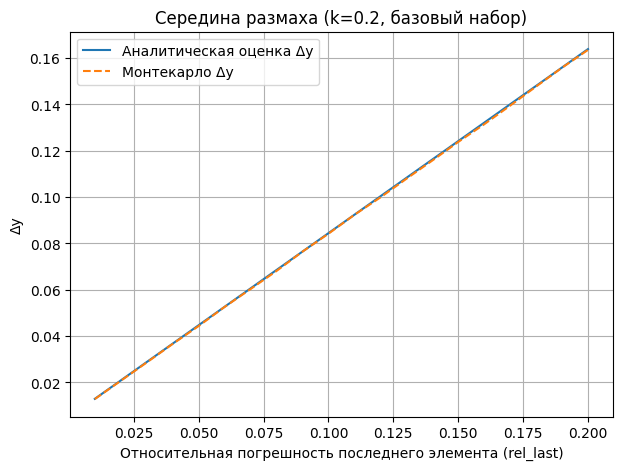

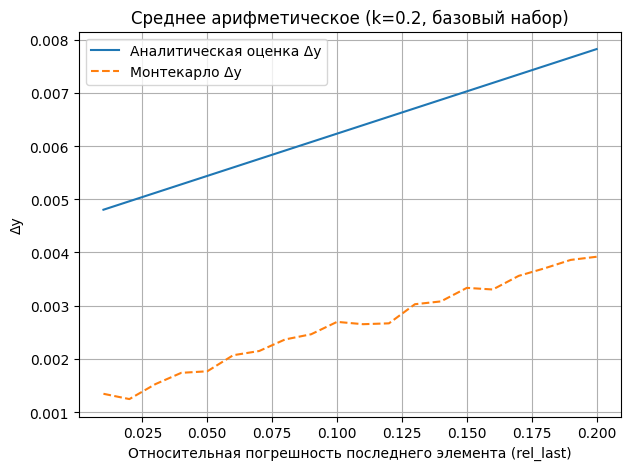

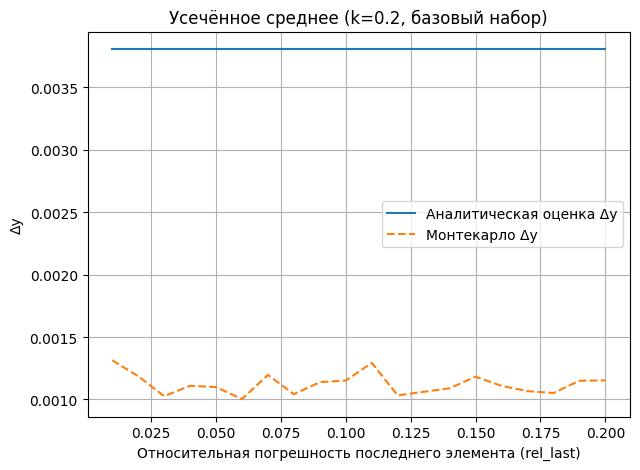

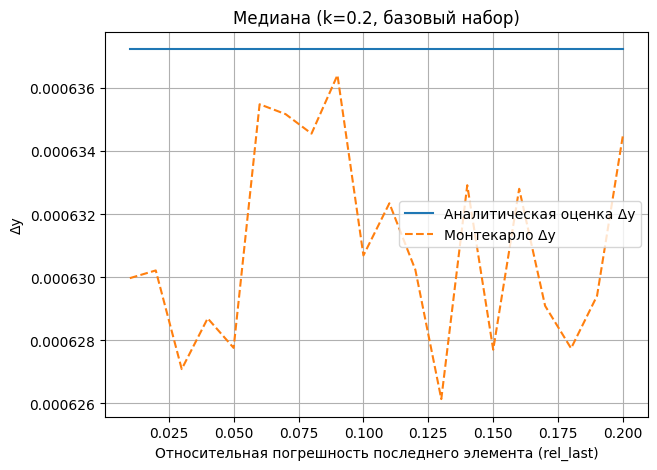

In [ ]:

plot_results(rel_last_values, analytic_res, mc_res, title_suffix=f"(k={k_default}, базовый набор)")



1 выброс(ов): [3.0]
midrange : analytic Δy (max) = 1.992638e-02 , MC Δy (max) = 1.965691e-02
mean     : analytic Δy (max) = 8.067240e-03 , MC Δy (max) = 3.922867e-03
trim     : analytic Δy (max) = 3.820257e-03 , MC Δy (max) = 1.025046e-03
median   : analytic Δy (max) = 6.372318e-04 , MC Δy (max) = 6.276436e-04


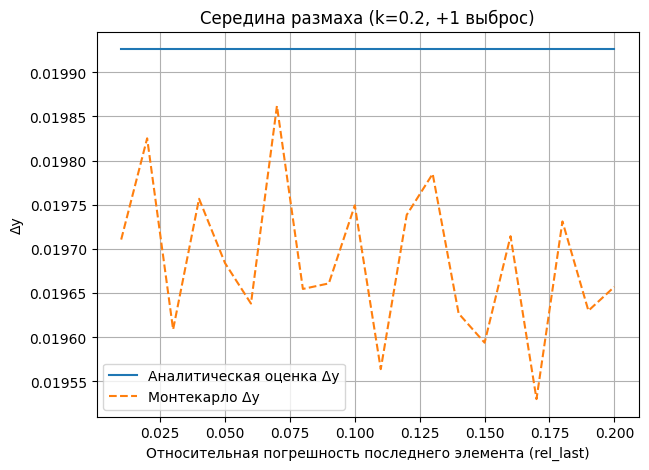

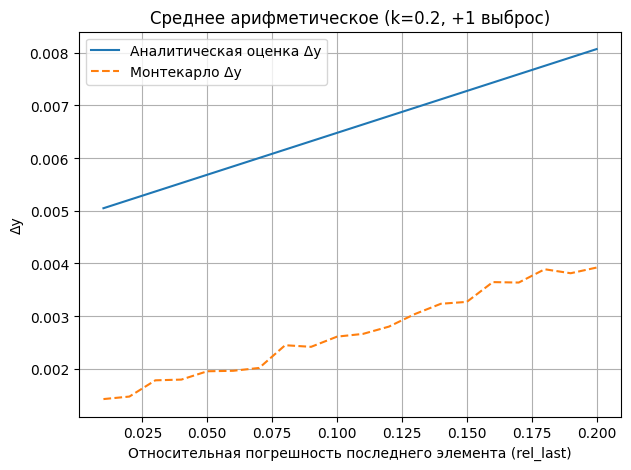

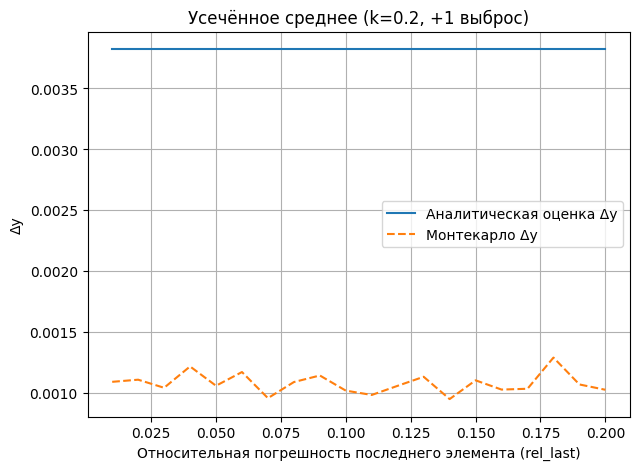

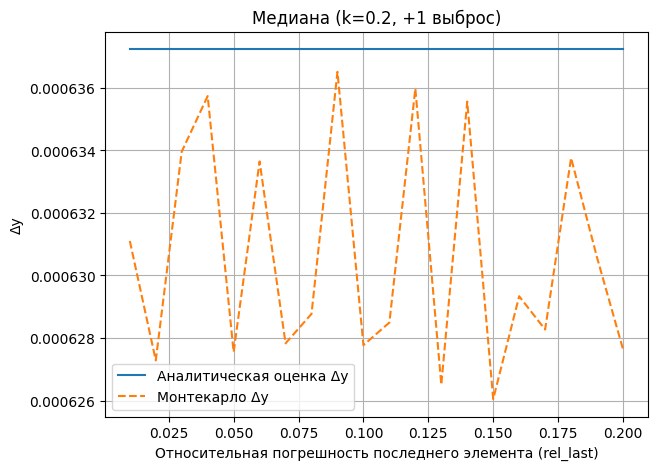


2 выброс(ов): [3.0, -2.5]
midrange : analytic Δy (max) = 2.750000e-02 , MC Δy (max) = 2.651768e-02
mean     : analytic Δy (max) = 8.305016e-03 , MC Δy (max) = 4.238849e-03
trim     : analytic Δy (max) = 3.901344e-03 , MC Δy (max) = 1.149705e-03
median   : analytic Δy (max) = 6.372318e-04 , MC Δy (max) = 6.298812e-04


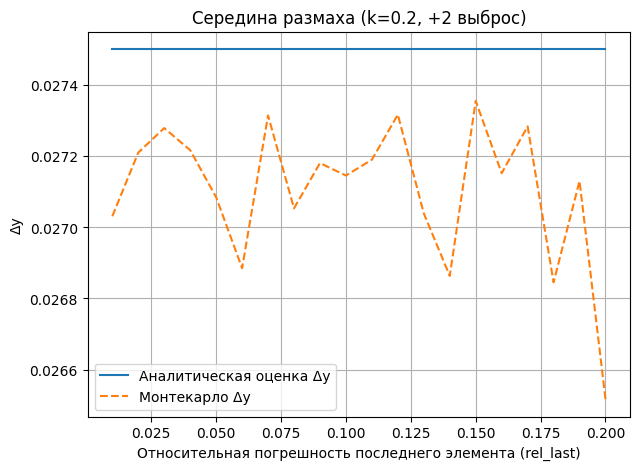

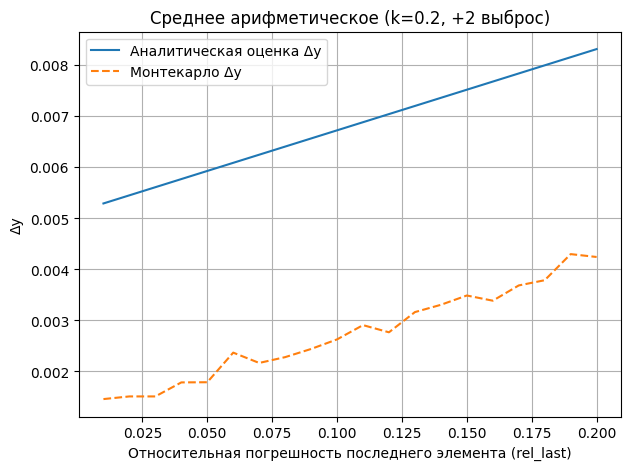

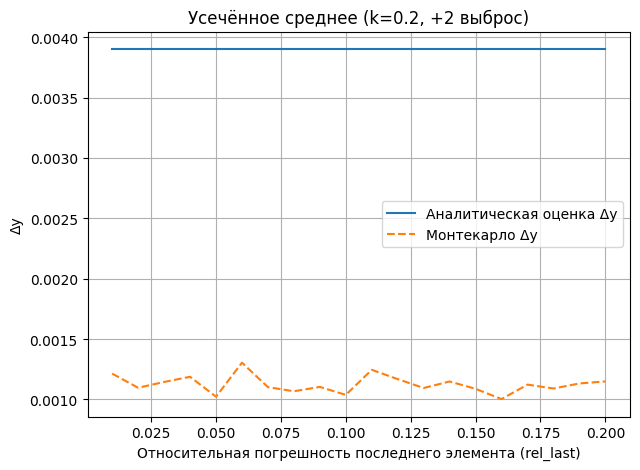

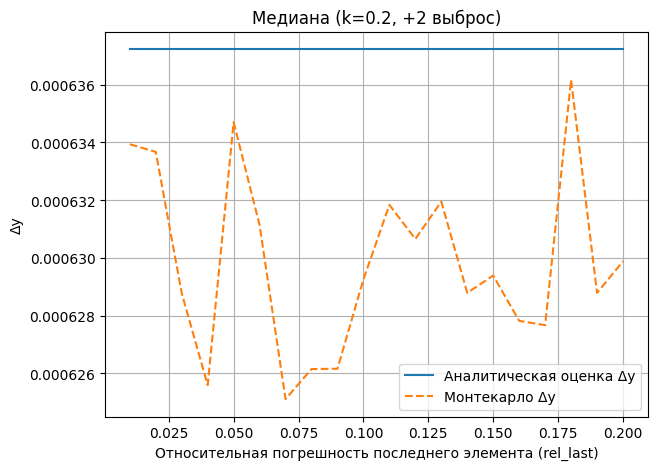


3 выброс(ов): [3.0, -2.5, 2.8]
midrange : analytic Δy (max) = 2.750000e-02 , MC Δy (max) = 2.737078e-02
mean     : analytic Δy (max) = 8.513297e-03 , MC Δy (max) = 4.223957e-03
trim     : analytic Δy (max) = 3.901344e-03 , MC Δy (max) = 1.220667e-03
median   : analytic Δy (max) = 6.372318e-04 , MC Δy (max) = 6.226603e-04


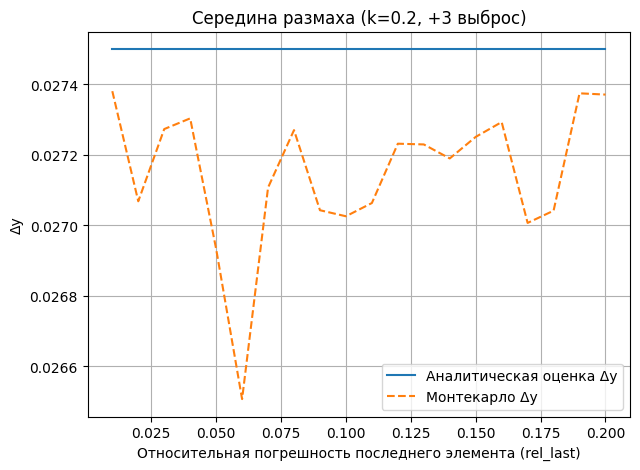

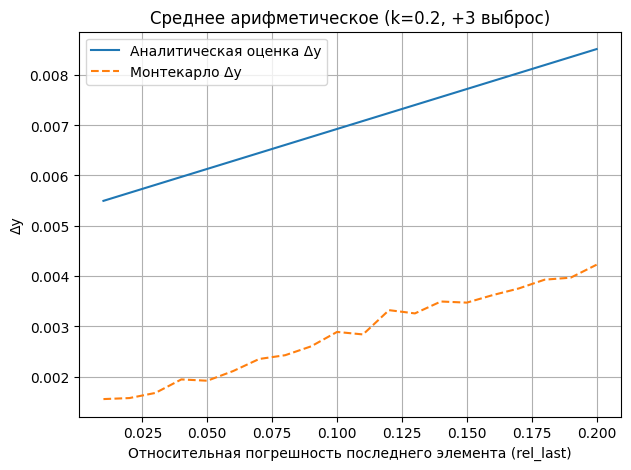

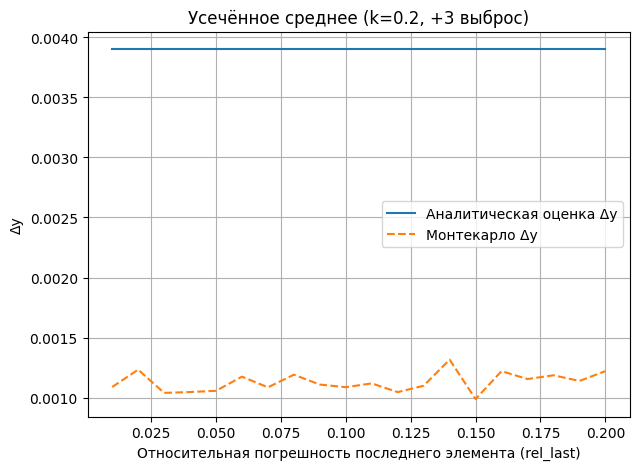

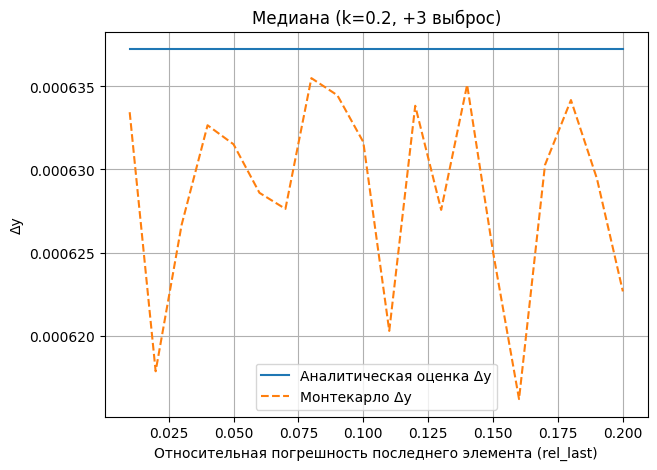

In [ ]:

extra_values = [
    [3.0],             
    [3.0, -2.5],       
    [3.0, -2.5, 2.8]   
]

for idx, extras in enumerate(extra_values, start=1):
    # создаём новую совокупность: берем первые (100 - len(extras) -1) случайных, затем extras, затем последний 1.589
    base_random = x0[:-1].copy()
    # заменим первые len(extras) элементов на выбранные выбросы 
    x_mod = base_random.copy()
    x_mod[:len(extras)] = extras
    x_mod = np.concatenate([x_mod, x0[-1:]])  

    # выполняем эксперимент
    analytic_mod, mc_mod = experiment_vary_last_delta(
        rel_last_values,
        x_mod,
        rel_default=0.01,
        k=k_default,
        N_mc=int(N_mc/2), 
        seed=2
    )

    
    print(f"\n{idx} выброс(ов): {extras}")
    for stat in ['midrange','mean','trim','median']:
        print(f"{stat:8s} : analytic Δy (max) = {analytic_mod[stat][-1]:.6e} , MC Δy (max) = {mc_mod[stat][-1]:.6e}")

    plot_results(rel_last_values, analytic_mod, mc_mod, title_suffix=f"(k={k_default}, +{idx} выброс)")


### a) Какая из оценок центра совокупности наименее робастная? Какая – наиболее робастная?

#### наименее робастная: середина размаха. Так как зависит от 2-ух крайних значений выборки

#### Самая робастная: медиана. Так как ориентируется на серединные элементы

### б) В чем причина схожей чувствительности к выбросам оценок среднего медианой и усеченным средним в настоящем примере?

#### Потому что обе оценки игнорируют крайние значения выборки. Медиана смотрит на серединные элементы, а усеченное среднее обрезает крайние значения

### в) Как увеличение и уменьшение значения k влияет на точность оценки центра совокупности усеченным средним? Как измерение значения k влияет на робастность данной оценки?

#### при увеличении: удаляем больше крайних значений -> более робастная оценка и меньше данных

### г) В каком случае оценка центра медианой предпочтительнее оценки усеченным средним?

#### Когда имеется большое количество выбросов.
#### Когда выборка имеет тяжелые хвосты, например как в распределении Лапласа или Коши
#### Когда требуется масимальная робастность, а точность не критична
#### Когда выборка несимметрична
#### Когда число измерений небольшое